# Graph neural networks - Practicals 1

### Installation of PyTorch

In [14]:
import torch
TORCH = torch.__version__.split('+')[0]
DEVICE = 'cu' + torch.version.cuda.replace('.', '') if torch.cuda.is_available() else 'cpu'

!pip install torch-sparse torch-scatter torch-cluster torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{DEVICE}.html
!pip install torch-geometric
!pip install networkx==3.1 matplotlib tqdm torchmetrics ipywidgets

Looking in links: https://pytorch-geometric.com/whl/torch-2.0.1+cpu.html


In [15]:
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
import torch_geometric.nn as gnn
import torch_geometric as tg
from torch_geometric.data import Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import TUDataset
import networkx as nx
import matplotlib.pyplot as plt
from typing import Tuple
# from tqdm.notebook import tqdm
from tqdm import tqdm


def train_and_eval(model : nn.Module, dataset : Dataset) -> Tuple[nn.Module, float]:
    """
    Train and evaluate the model on the dataset.
    A boilerplate for training and evaluating a neural network.

    Args:
        model (nn.Module): The model to train and evaluate.
        dataset (Dataset): The dataset to train and evaluate on.

    Returns:
        nn.Module: The trained model with the best validation accuracy.
        float: The best validation accuracy.
    """

    # init training and validation dataloaders
    dataloader_train = DataLoader(dataset[:150], batch_size=16, shuffle=True)
    dataloader_val = DataLoader(dataset[150:], batch_size=16, shuffle=True)

    # init optimizer and loss
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()

    # init metrics
    metric_loss_train = torchmetrics.MeanMetric()
    metric_accuracy_train = torchmetrics.Accuracy(task="multiclass", num_classes=dataset.num_classes)
    metric_accuracy_val = torchmetrics.Accuracy(task="multiclass", num_classes=dataset.num_classes)

    best_model_params = None
    best_val_acc = 0.0

    # training loop
    num_epochs = 100
    epoch_bar = tqdm(list(range(num_epochs)), desc="Epochs" + " "*100)
    for epoch in epoch_bar:

        # training loop
        for data in dataloader_train:
            model.train()
            optimizer.zero_grad()
            logits = model(data.x, data.edge_index, data.batch)
            loss = criterion(logits, data.y)
            loss.backward()
            optimizer.step()

            metric_loss_train(loss)
            metric_accuracy_train(logits.argmax(dim=1), data.y)

        # evaluation loop
        for data in dataloader_val:
            model.eval()
            with torch.no_grad():
                logits = model(data.x, data.edge_index, data.batch)
                pred = logits.argmax(dim=1)
                metric_accuracy_val(pred, data.y)


        train_loss = metric_loss_train.compute().item()
        train_acc = metric_accuracy_train.compute().item()
        val_acc = metric_accuracy_val.compute().item()

        # progress bar
        epoch_bar.set_description("".join([
            f'Epoch: {epoch+1:03d} | ',
            f'Val Acc: {val_acc:.3f} | ',
            f'Train Acc: {train_acc:.3f} | ',
            f'Train Loss: {train_loss:.3f} | ',
            ]))

        # update best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()

    best_model = model
    best_model.load_state_dict(best_model_state)

    return best_model, best_val_acc

### Download training data

**Datasets**

Comparing to other Fully-Connected Neural Networks (NNs) or Convolutional Neural Networks (CNNs),

Graph neural networks (GNNs) require have two basic datapoints: a graph structure and a feature matrix.

In [16]:
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='data/TUDataset', name='MUTAG')

### Define our model

We will use the `nn.Module` class from PyTorch to define our model.
Since having multiple datapoints we need to define a model that has multiple inputs in the `forward` function.



In [17]:
class GraphNetModel(nn.Module):

    def __init__(self, num_features, num_classes, gnnLayer=None):
        super().__init__()

        # in case no gnnLayer is provided, use GraphConv
        if gnnLayer is None:
            gnnLayer = gnn.SGConv

        # first graph covolutional layer
        self.conv1 = gnnLayer(num_features, 32)

        # TODO🚀(optional):
        # - add more conv layers

        # last graph convolutional layer
        self.convL = gnnLayer(32, 32)

        # TODO🚀(optional):
        # - in many tutorials, the stantard dropout layer
        #    on **features** is used which can help
        #    with overfitting. Simlarly, the standard
        #    batch normalization can be used as well.
        # - `self.dropout = nn.Dropout(0.5)`
        # - `self.batchnorm = nn.BatchNorm1d(32)`

        self.linear = nn.Linear(32, num_classes)

    def forward(self, x, edge_index, batch):

        # apply first layer and follow with ReLU
        x = self.conv1(x, edge_index).relu()

        # TODO🚀(optional):
        # - apply more conv layers

        x = self.convL(x, edge_index).relu()

        # this (set) pooling makes the function
        # invariant to the order of the nodes
        x = gnn.global_mean_pool(x, batch)

        # TODO🚀(optional):
        # add dropout or batchnorm of features
        # - `x = self.dropout(x)`

        # apply linear layer
        x = self.linear(x)

        return x

### Perform training and evaluation

In [18]:
model = GraphNetModel(dataset.num_features, dataset.num_classes)
model, val_accuracy = train_and_eval(model, dataset)

print("Model size:", sum(p.numel() for p in model.parameters()))
print("Validation Accuracy:", val_accuracy)

Epoch: 002 | Val Acc: 0.684 | Train Acc: 0.650 | Train Loss: 0.644 | :   2%|▏         | 2/100 [00:00<00:20,  4.75it/s]                             

Epoch: 100 | Val Acc: 0.690 | Train Acc: 0.754 | Train Loss: 0.506 | : 100%|██████████| 100/100 [00:09<00:00, 10.21it/s]

Model size: 1378
Validation Accuracy: 0.7017543911933899


### [Task 1] Implementing the (simple) Graph Convolutional Layer (GCN)


$$
\begin{align}
\hat{D} &= D + I \\
\hat{A} &= A + I \\
\tilde{A} &= \hat{D}^{-1/2} \hat{A} \hat{D}^{-1/2} \\
F^{(t+1)} &= \sigma(\tilde{A} F^{(t)} W^{(t)} + b^{(t)})
\end{align}
$$

In [19]:
class OurGCNLayer(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()

        # initialize linear layer with weight `W` and bias `b`
        self.linear = nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        nx = x.shape[0]

        # create abstraction of sparse adjacency matrix from edge_index
        A = torch.sparse_coo_tensor(edge_index, torch.ones_like(edge_index[0]).float(), size=(nx, nx))

        # also sparse identity matrix
        I = torch.sparse_coo_tensor(torch.stack([torch.arange(nx), torch.arange(nx)]), torch.ones(nx).float(), size=(nx, nx))

        # add self-loops
        A_hat = A + I

        # degree vector
        deg_inv_sqrt = A_hat.sum(dim=1).to_dense().pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0.0

        # normalized inverse degree matrix
        Di = I * deg_inv_sqrt
        assert Di.is_sparse

        # using bias and weight of linear layer
        W = self.linear.weight.T
        b = self.linear.bias

        # normalize adjacency matrix
        A_norm = Di @ A_hat @ Di
        assert A_norm.is_sparse

        x = A_norm @ x @ W + b
        return x


**train model with GCN Layer:**

In [20]:
model_our1 = GraphNetModel(dataset.num_features, dataset.num_classes, gnnLayer=OurGCNLayer)
trained_model_our1, val_accuracy_our1 = train_and_eval(model_our1, dataset)

print("Model size:", sum(p.numel() for p in model_our1.parameters()))
print("Validation Accuracy:", val_accuracy_our1)

Epoch: 001 | Val Acc: 0.684 | Train Acc: 0.540 | Train Loss: 0.695 | :   1%|          | 1/100 [00:00<00:11,  8.29it/s]                             

Epoch: 100 | Val Acc: 0.702 | Train Acc: 0.762 | Train Loss: 0.502 | : 100%|██████████| 100/100 [00:11<00:00,  8.60it/s]

Model size: 1378
Validation Accuracy: 0.7021052837371826


In [21]:
#  Following is just for debugging purposes


# from collections import OrderedDict

# loader = DataLoader(dataset, batch_size=16, shuffle=True)
# for data in loader:
#     break

# layer1 = OurGCNLayer(dataset.num_features, dataset.num_classes)
# layer0 = gnn.GCNConv(dataset.num_features, dataset.num_classes, add_self_loops=True, normalize=True, improved=False)

# sd0 = layer0.state_dict()
# sd1 = OrderedDict([
#     ('linear.weight', sd0['lin.weight']),
#     ('linear.bias', sd0['bias']),
# ])

# layer0.load_state_dict(sd0)
# layer1.load_state_dict(sd1)


# y1 = layer1(data.x, data.edge_index)
# y0 = layer0(data.x, data.edge_index)

# print("Difference between our implementation and PyG:", (y1 - y0).abs().mean().item())

### But what structures are our models really capturing?

Consider the following graphs:

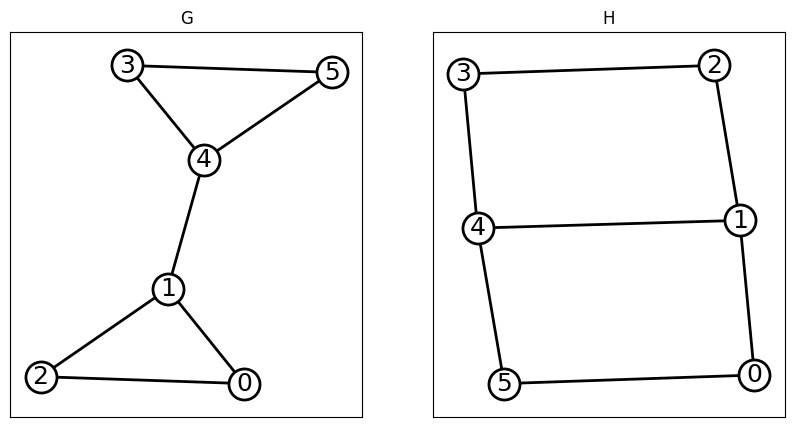

In [22]:
graph_G = nx.from_edgelist([(0,1), (1,2), (2,0), (3,4), (4,5), (5,3), (1,4)])
graph_H = nx.from_edgelist([(0,1), (1,2), (2,3), (3,4), (4,5), (5,0), (1,4)])

def to_edge_index(graph):
    return torch.tensor(list(nx.to_directed(graph).edges)).T

options = {
    "font_size": 18,
    "node_size": 500,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 2,
    "width": 2,
}

plt.subplots(1,2, figsize=(10,5))
plt.subplot(121)
plt.title("G")
nx.draw_networkx(graph_G, **options)
plt.subplot(122)
plt.title("H")
nx.draw_networkx(graph_H, **options)
plt.show()

### So why are outputs identical if the graphs are clearly not isomorphic?
"... because of 1-WL"

In [23]:
model_our1.eval()

# simple features to test the model
features = torch.ones(6, 7).float()
batch = torch.zeros(6).long()

logits_G = model_our1(features, to_edge_index(graph_G), batch)
logits_H = model_our1(features, to_edge_index(graph_H), batch)

print("Prediction for G: ", logits_G.detach().numpy())
print("Prediction for H:", logits_H.detach().numpy())

Prediction for G:  [[ 14.820637 -13.990431]]
Prediction for H: [[ 14.820636 -13.990431]]


### However,

we can still try to break this symetry by permutation invariant operations such as node deletion.
Clearly, the following sets of graphs are not even have the same degree sequences.

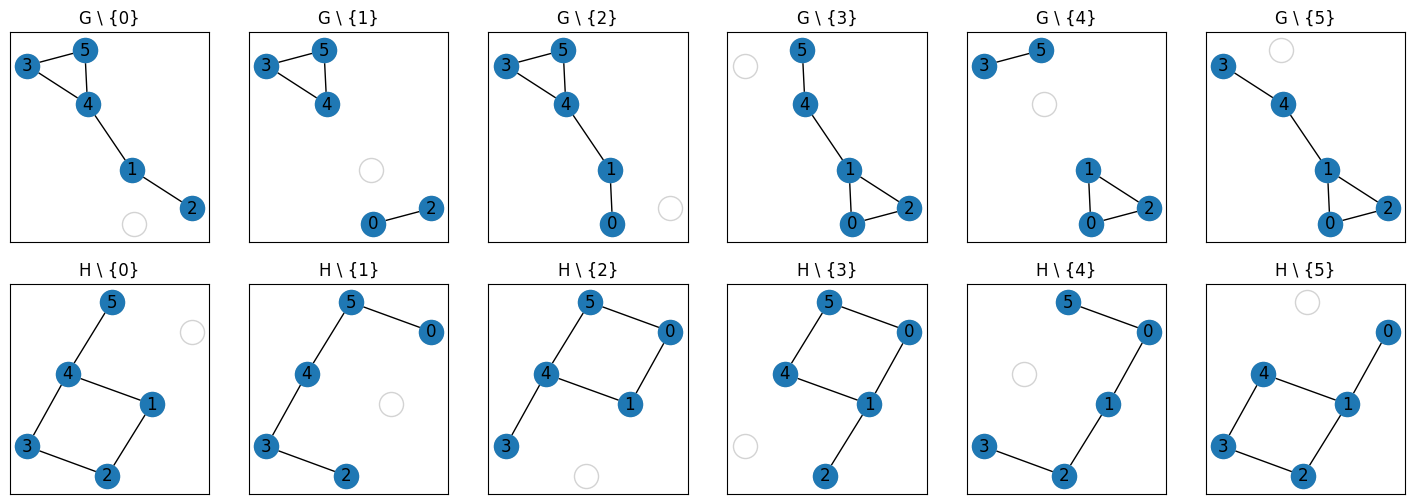

In [24]:
def bag_subgraphs(x, edge_index, batch, no_concat=False):
    """similar method as delete_node_from_graph_invariantly
    """
    bagged_x, bagged_edge_index, bagged_batch = [], [], []

    indices = torch.arange(x.size(0))
    lower_bound = 0

    # for all graphs in a batch
    for batch_i in torch.unique(batch):
        vertex_mask = batch == batch_i
        x_i = x[vertex_mask]
        nx_i = x_i.size(0)
        vertex_idcs = indices[vertex_mask]
        min_idx, max_idx = vertex_idcs.min(), vertex_idcs.max()
        edge_index_i = edge_index[:, torch.logical_and(
            edge_index[0] >= min_idx,
            edge_index[0] <= max_idx)] - min_idx

        # delete j-th vertex
        for j in range(nx_i):
            x_ij = torch.cat([x_i[:j], x_i[j+1:]])
            bagged_x.append(x_ij)

            edge_index_ij = edge_index_i[:, torch.logical_and(
                    edge_index_i[0] != j,
                    edge_index_i[1] != j)]
            edge_index_ij[0][edge_index_ij[0] > j] -= 1
            edge_index_ij[1][edge_index_ij[1] > j] -= 1
            bagged_edge_index.append(edge_index_ij + lower_bound)

            lower_bound += nx_i - 1

        bagged_batch.append(torch.zeros((nx_i - 1) * nx_i, dtype=torch.long) + batch_i)

    if no_concat:
        return (
            bagged_x,
            bagged_edge_index,
            bagged_batch
        )

    return (
        torch.cat(bagged_x),
        torch.cat(bagged_edge_index, dim=1),
        torch.cat(bagged_batch)
    )


def delete_node_from_graph_invariantly(graph : nx.Graph):
    n = graph.number_of_nodes()
    x, edge_index, _ = bag_subgraphs(
        torch.arange(n),
        to_edge_index(graph),
        torch.zeros(n),
        no_concat=True
    )

    graphs = []
    for x_i, edge_index_i in zip(x, edge_index):
        g = nx.from_edgelist((edge_index_i-edge_index_i.min()).T.tolist())
        nx.relabel_nodes(g, dict(enumerate(x_i.tolist())), copy=False)
        graphs.append(g)

    return graphs

sett = dict(node_color="white", edgecolors="lightgrey", width=0, with_labels=False)
plt.subplots(2,6, figsize=(18,6))
pos = nx.spring_layout(graph_G, seed=42)
subgraphs = delete_node_from_graph_invariantly(graph_G)
for ci, g in enumerate(subgraphs):
    plt.subplot(2,6,ci+1)
    plt.title(f"G \ {{{ci}}}")
    nx.draw_networkx(graph_G, pos, **sett)
    nx.draw_networkx(g, pos)
pos = nx.spring_layout(graph_H, seed=42)
subgraphs = delete_node_from_graph_invariantly(graph_H)
for ci, g in enumerate(subgraphs):
    plt.subplot(2,6,ci+7)
    plt.title(f"H \ {{{ci}}}")
    nx.draw_networkx(graph_G, pos, **sett)
    nx.draw_networkx(g, pos)

plt.show()


In [25]:
class OrderedSubgraphAggregationModel(GraphNetModel):

    def forward(self, x, edge_index, batch):

        # blow up the graphs into all possible vertex deletion subgraphs
        x, edge_index, batch = bag_subgraphs(x, edge_index, batch)

        # TODO🚀(optional):
        # - one can theoreticaly the previs line multiple times
        #   to get all possible subgraphs of subgraphs (k-OSAN)
        #   however other hyperparameters need to be
        #   adjusted as well since the time complexity explodes
        # - `x, edge_index, batch = bag_subgraphs(x, edge_index, batch)`

        return super().forward(x, edge_index, batch)

In [26]:
model_our2 = OrderedSubgraphAggregationModel(dataset.num_features, dataset.num_classes, OurGCNLayer)
trained_model_our2, val_accuracy_our2 = train_and_eval(model_our2, dataset)

print("Model size:", sum(p.numel() for p in model_our2.parameters()))
print("Validation Accuracy:", val_accuracy_our2)

Epoch: 100 | Val Acc: 0.713 | Train Acc: 0.762 | Train Loss: 0.487 | : 100%|██████████| 100/100 [00:51<00:00,  1.96it/s]                           

Model size: 1378
Validation Accuracy: 0.7128947377204895


Hey! Now our model not only has a better accuracy, but also is

### More expressive ?!

In [27]:
model_our2.eval()

# simple features to test the model
features = torch.ones(6, 7).float()
batch = torch.zeros(6).long()

logits_G = model_our2(features, to_edge_index(graph_G), batch)
logits_H = model_our2(features, to_edge_index(graph_H), batch)

print("Prediction for G: ", logits_G.detach().numpy())
print("Prediction for H:", logits_H.detach().numpy())

Prediction for G:  [[-1.394305  -2.8376994]]
Prediction for H: [[-1.3939359 -2.8205943]]
